In [8]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Rescaling
import tensorflow as tf; tf.config.set_visible_devices([], 'GPU')

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = Rescaling(scale=1.0 / 255.0)(X_train)
X_test = Rescaling(scale=1.0 / 255.0)(X_test)

print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


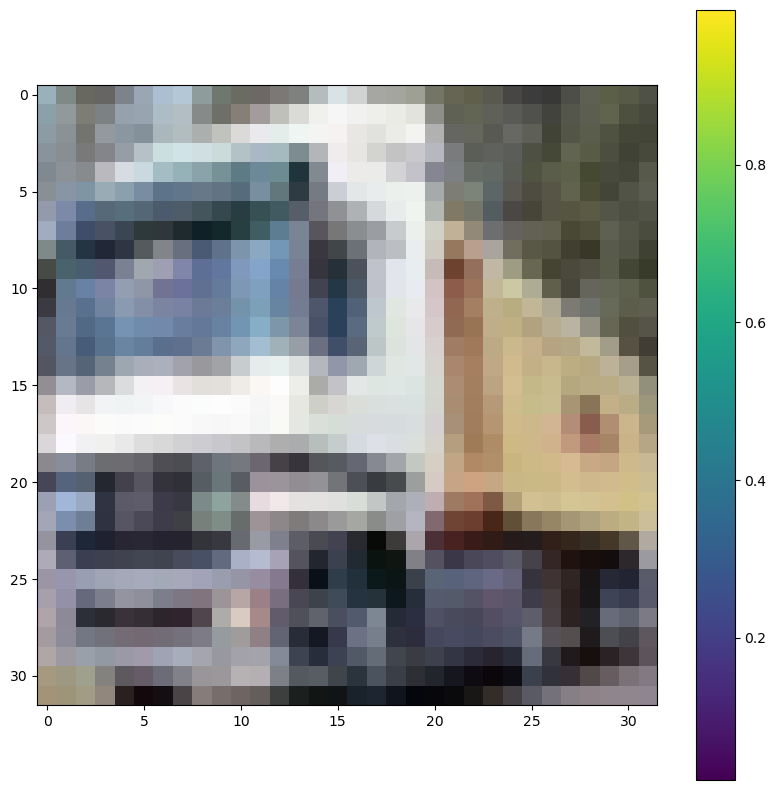

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(X_train[1])
plt.colorbar()
plt.show()

# Build CNN

In [9]:
model = Sequential()
model.add(Input(shape=(32, 32, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(80, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Train model

In [10]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10


2024-05-27 15:16:46.735326: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1094/1094 [==============================] - 9s 8ms/step - loss: 1.5071 - accuracy: 0.4563 - val_loss: 1.3351 - val_accuracy: 0.5359
Epoch 2/10
1094/1094 [==============================] - 8s 8ms/step - loss: 1.1511 - accuracy: 0.5921 - val_loss: 1.1051 - val_accuracy: 0.6139
Epoch 3/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.9792 - accuracy: 0.6549 - val_loss: 1.0744 - val_accuracy: 0.6198
Epoch 4/10
1094/1094 [==============================] - 8s 8ms/step - loss: 0.8594 - accuracy: 0.6982 - val_loss: 1.0612 - val_accuracy: 0.6331
Epoch 5/10
1094/1094 [==============================] - 8s 8ms/step - loss: 0.7501 - accuracy: 0.7372 - val_loss: 1.0393 - val_accuracy: 0.6471
Epoch 6/10
1094/1094 [==============================] - 8s 8ms/step - loss: 0.6556 - accuracy: 0.7705 - val_loss: 1.0314 - val_accuracy: 0.6679
Epoch 7/10
1094/1094 [==============================] - 9s 8ms/step - loss: 0.5620 - accuracy: 0.8023 - val_loss: 1.1345 - val_accuracy: 0.6491
Epo

# Plot the graph

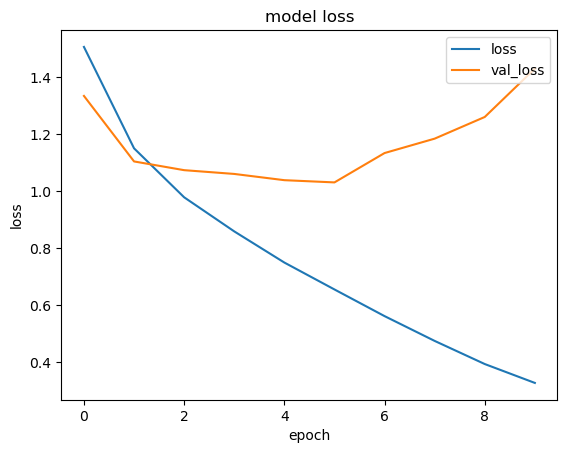

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# Confirm model

313/313 [==============================] - 1s 3ms/step
Predicted Answer: 3
Answer: [3]


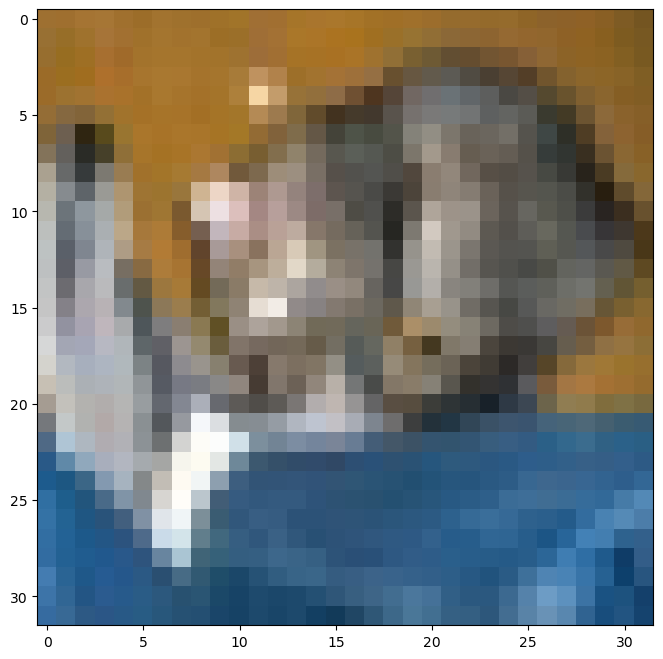

In [14]:
y_pred = model.predict(X_test)
print(f'Predicted Answer: {y_pred[0].argmax()}')
print(f'Answer: {y_test[0]}')

plt.figure(figsize=(8, 8))
plt.imshow(X_test[0])
plt.show()

# Test real image

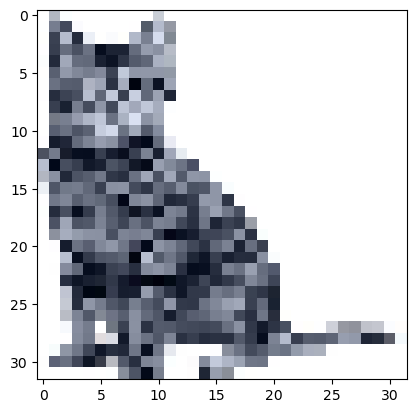

In [62]:
import cv2 as cv

def preprocess_image(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img, (32, 32))
    img = Rescaling(scale=1.0 / 255.0)(img)
    img = img.numpy().reshape(1,32,32,3)
    
    return img

image = preprocess_image('cat.jpg')
plt.imshow(image.reshape(32,32,3))
plt.show()

In [58]:
@tf.function
def predict_image(model, image):
    return model(image)

pred = predict_image(model, image)
print(f"Predicted probability: {pred}")
print(f'predicted number = {pred.numpy().argmax()}')

Predicted probability: [[9.8874950e-01 9.5802499e-03 1.9726447e-05 6.4002838e-06 4.0218147e-06
  7.4158493e-09 3.6072183e-06 7.1589426e-07 8.6172222e-04 7.7415118e-04]]
predicted number = 0
